In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import IsolationForest
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# import dataset for classification of PD and controls

path = r'/content/drive/MyDrive/Parkinson_prediction/Parkinson_controls.xls'
df = pd.read_excel(path,usecols=[0,2,4,5,12,14,15,16,17,18,19,20,21,22,23,24,25,26],index_col=0,na_values=['inf','NaN'])

# drop na
df.dropna(inplace=True)

# encode gender and group in binary format
df.replace(['male','female'],[1,0],inplace=True)
df.replace(['PD','CO'],[1,0],inplace=True)

# set X and y
y = df['Group'].values
X = df.drop(['Group'],axis=1).values
column_names = df.drop(['Group'],axis=1).columns

# Set new X and new y after outlier removal using Isolation Forest algorithm
isofor = IsolationForest(contamination=0.1)
y_hat = isofor.fit_predict(X)
mask = y_hat != -1
X_clean, y_clean = X[mask, :], y[mask]

# print rows with existing nan values
print(df[df.isna().any(axis=1)])

# see target variable balance
print(df['Group'].value_counts())


Empty DataFrame
Columns: [Group, Gender, Age, Speed_01 (m/sec), mean_stride_times, cv_stride_times, no_strides, dfa_4_8, dfa_4_10, dfa_4_12, dfa_4_14, sampen_2_020, sampen_2_025, sampen_2_030, sampen_3_025, sampen_3_030, Leg Imbalance]
Index: []
1    79
0    61
Name: Group, dtype: int64


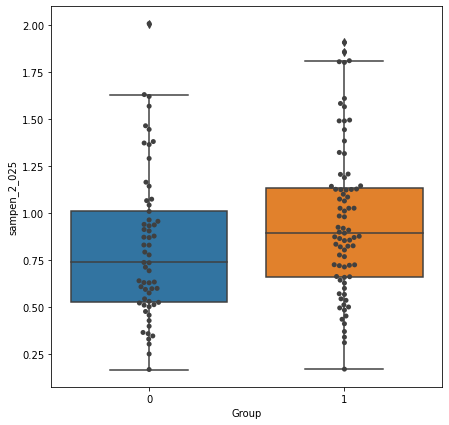

Outliers for parkinson are (array([1.85781593, 1.90782636]), [(array([2]),), (array([68]),)])
Outliers for controls are (array([2.00829689]), [(array([43]),)])
MannwhitneyuResult(statistic=1901.5, pvalue=0.016472690639489154)


In [3]:
# plot categorical feature
plt.figure(figsize=[7,7])
sns.boxplot(x='Group',y='sampen_2_025',data=df)
sns.swarmplot(x='Group',y='sampen_2_025',data=df,color='0.25')
plt.show()

# Perform ttest and mannwhitney on variables of interest between 2 different stages of parkinson
X1 = df['sampen_2_025'][df['Group']==1].values
X2 = df['sampen_2_025'][df['Group']==0].values

# detect outliers id from boxplot with interquartile range method
def detect_outliers(array):
  q1 = np.quantile(array,0.25)
  q3 = np.quantile(array,0.75)
  iqr = q3-q1
  upper_bound = q3 + (1.5*iqr)
  lower_bound = q1 - (1.5*iqr)
  outliers = array[(array<=lower_bound) | (array>=upper_bound)]
  outliers_indices = []
  for outlier in outliers:
    index = np.where(array==outlier)
    outliers_indices.append(index)
  return outliers, outliers_indices

print('Outliers for parkinson are {}'.format(detect_outliers(X1)))
print('Outliers for controls are {}'.format(detect_outliers(X2)))

# See distribution for X1 and X2 and perform ttest and MannWhitney tests. If normal distribution, see ttest statistics, if not normal see mannwhitney statistics
if shapiro(X1)[1] >= 0.05 or shapiro(X2)[1] >= 0.05:
  print(ttest_ind(X1,X2,equal_var=False))

else:
  print(mannwhitneyu(X1,X2))

In [4]:
'''VIF'''

# detect multicollinearity with variance inflation factor

df_vif = pd.DataFrame()
df_vif["Feature"] = column_names
df_vif["VIF"] = [variance_inflation_factor(X,i) for i in range(X.shape[1])]
print(df_vif.sort_values(by=['VIF']))

              Feature         VIF
15      Leg Imbalance    2.323968
0              Gender    2.907931
4     cv_stride_times   11.824731
6             dfa_4_8   16.730676
10       sampen_2_020   25.938893
2    Speed_01 (m/sec)   35.799848
5          no_strides   50.200160
1                 Age   56.053349
3   mean_stride_times   67.101750
7            dfa_4_10   81.811054
13       sampen_3_025  114.649356
9            dfa_4_14  118.073430
14       sampen_3_030  120.915708
8            dfa_4_12  141.104712
11       sampen_2_025  168.412120
12       sampen_2_030  169.635783


  Created wheel for collinearity: filename=collinearity-0.6.1-py3-none-any.whl size=4459 sha256=e31f868191a397a83c18573365003e948a34c44855896377b14d432b531f2f9e
  Stored in directory: /root/.cache/pip/wheels/31/bf/74/0a475ad9095545c56fe02d678ccd38739baa81513e877d91ca
Successfully built collinearity


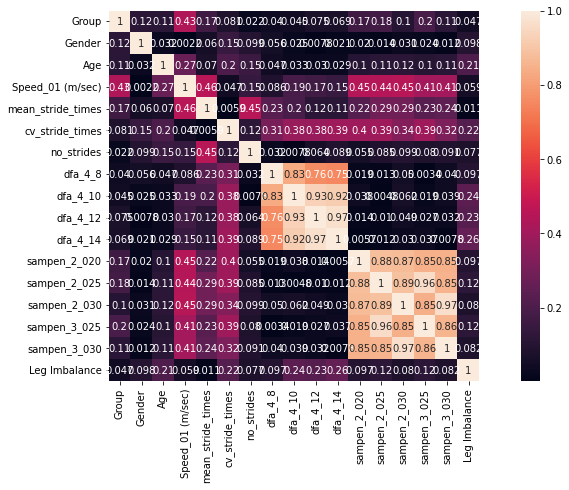

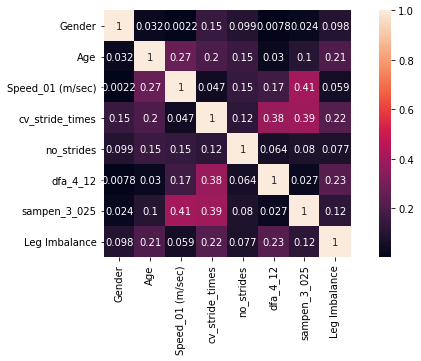

In [5]:
!pip install collinearity
from collinearity import SelectNonCollinear

selector = SelectNonCollinear(0.5)
selector.fit(X,y)
mask = selector.get_support()
df_non_collinear = pd.DataFrame(X[:,mask],columns=np.array(column_names)[mask])

plt.figure(figsize=[15,15])
plt.subplot(2,1,1)
sns.heatmap(df.corr(method='spearman').abs(),square=True,annot=True)
plt.show()

plt.figure(figsize=[10,10])
plt.subplot(2,1,2)
sns.heatmap(df_non_collinear.corr(method='spearman').abs(),square=True,annot=True)
plt.show()



In [6]:
'''Partial Least Squares VIP scores'''

# partial least squares vip scores (more suitable for variable selection when multicollinearity is present)
# we defined good predictors when vip score > 1, as it's suggested by the paper from Il-Gyo Chong & Chi-Hyuck Jun 2005
# function calculate_vips was found on a researchgate forum written by Keiron Teilo O'Shea

def calculate_vips(model):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

# standardize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)

pls = PLSRegression()
pls.fit_transform(scaled_data,y)
vip = calculate_vips(pls)
df_pls_vip = pd.DataFrame()
df_pls_vip["Feature"] = column_names
df_pls_vip["VIP SCORE"] = vip
df_pls_vip["Beta SCORE"] = np.abs(pls.coef_)
print(df_pls_vip.sort_values(by = ["VIP SCORE"],ascending = False))

              Feature  VIP SCORE  Beta SCORE
2    Speed_01 (m/sec)   2.419198    0.164527
12       sampen_2_030   1.345839    0.037276
14       sampen_3_030   1.142682    0.017698
11       sampen_2_025   1.063549    0.007566
10       sampen_2_020   0.999989    0.014761
13       sampen_3_025   0.962810    0.020256
3   mean_stride_times   0.903745    0.043433
4     cv_stride_times   0.799611    0.054518
0              Gender   0.763797    0.053308
7            dfa_4_10   0.612808    0.005474
6             dfa_4_8   0.592957    0.012544
8            dfa_4_12   0.573360    0.015696
9            dfa_4_14   0.532319    0.005766
5          no_strides   0.531015    0.036830
1                 Age   0.490198    0.018774
15      Leg Imbalance   0.267084    0.016109


In [9]:
'''Principal Component Analysis'''

# standardize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)

# use principal component analysis to find features that explain data's variance the most
pca = PCA(n_components=15)
pca.fit_transform(scaled_data)

#sort most important components
most_important_comp = [np.abs(pca.components_[i]).argmax() for i in range(15)]
most_important_features = [column_names[most_important_comp[i]] for i in range(15)]
print("PCA's most important features are {}".format(most_important_features))

PCA's most important features are ['Gender', 'sampen_2_025', 'dfa_4_14', 'Age', 'Leg Imbalance', 'no_strides', 'no_strides', 'cv_stride_times', 'dfa_4_8', 'sampen_3_030', 'mean_stride_times', 'sampen_2_020', 'dfa_4_10', 'sampen_2_020', 'dfa_4_12']


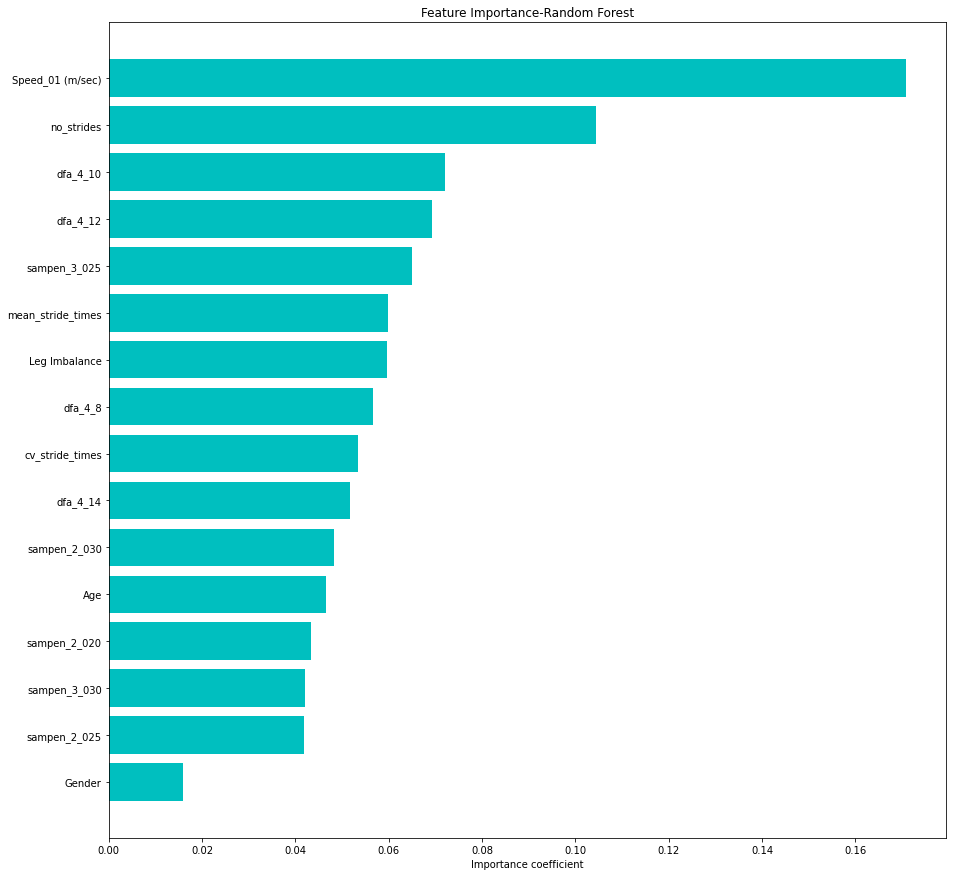

In [10]:
'''Random Forest Classifier'''

# use random forest to find feature importance coefficients
rand_for = RandomForestClassifier()
rand_for.fit(X,y)
feature_importance = rand_for.feature_importances_
indices = np.argsort(feature_importance)

# plot random forest feature importance coefficients
plt.figure(figsize=[15,15])
plt.barh(range(len(indices)),feature_importance[indices],color ="c",align="center")
plt.yticks(range(len(indices)),[column_names[i] for i in indices])
plt.title("Feature Importance-Random Forest")
plt.xlabel("Importance coefficient")
plt.show()

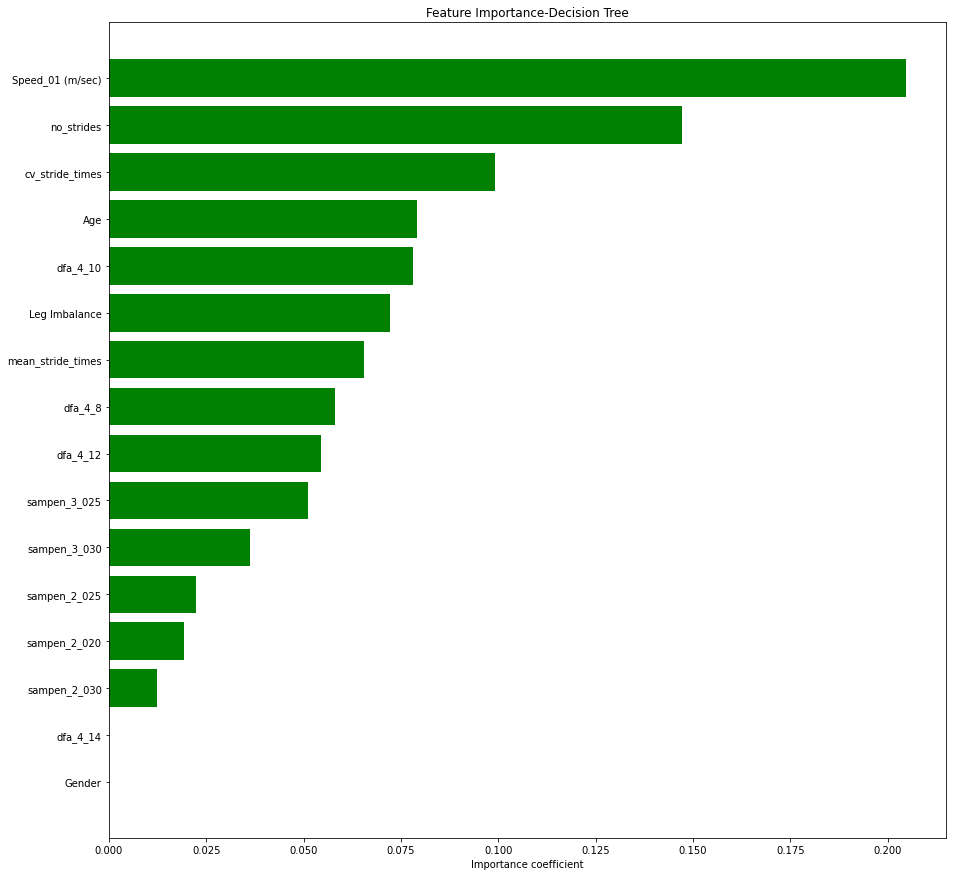

In [11]:
'''Decision Tree'''

# use decision tree to find feature importance coefficients
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X,y)
best_features = dec_tree.feature_importances_
index = np.argsort(best_features)

# plot decision tree feature importance coefficients
plt.figure(figsize=[15,15])
plt.barh(range(len(index)),best_features[index],color ="g",align="center")
plt.yticks(range(len(index)),[column_names[i] for i in index])
plt.title("Feature Importance-Decision Tree")
plt.xlabel("Importance coefficient")
plt.show()

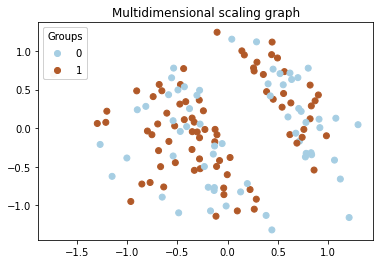

In [14]:
from sklearn.manifold import MDS

mds = MDS(n_components=2,random_state=0,metric=True)
mds_coordinates = mds.fit_transform(scaled_data)

mds_df = pd.DataFrame(mds_coordinates,columns=["x","y"],index=df.index)
mds_df = pd.concat([mds_df,pd.Series(df['Group'])],axis=1)

fig, ax = plt.subplots()

scatter = ax.scatter(mds_df.x, mds_df.y,c=mds_df['Group'],cmap=plt.cm.Paired)
plt.title('Multidimensional scaling graph')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Groups")
ax.add_artist(legend1)

#for sample in mds_df.index:
    #plt.annotate(sample,(mds_df.x.loc[sample],mds_df.y.loc[sample]))
plt.show()